In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
from scipy.optimize import curve_fit 
from scipy.stats import norm, lognorm

## Data Preprocessing

In [4]:
freq = '15min'
lags = 32
preds = 3

### Load time index and links indexes for each line to transfer site

In [5]:
data_test_200S = pd.read_csv('Data/200S_15min_test_raw.csv.gz', index_col=0, parse_dates=['Time'])
lns_200s = np.arange(len(data_test_200S.columns))[data_test_200S.columns.isin(['52396:11'])]
ix_test = data_test_200S.index[lags:-preds]
ix_test_rev = {k:v for v,k in enumerate(ix_test)}
ix_test.shape

(1309,)

In [6]:
data_test_300S = pd.read_csv('Data/300S_15min_test_raw.csv.gz', index_col=0, parse_dates=['Time'])
lns_300s = np.arange(len(data_test_300S.columns))[data_test_300S.columns.isin(['6:8', '8:9','9:11'])]
lns_300s

array([11, 12, 13])

### Load model outputs, including samples

In [7]:
dqr_300s_y_test_pred_ = np.load('DQR/y_test_pred_joint_300s.npy')
dqr_300s_y_test_mean = np.load('DQR/y_test_mean_300s.npy')
dqr_300s_y_test_std = np.load('DQR/y_test_std_300s.npy')
dqr_300s_y_test = np.load('DQR/y_test_300s.npy')
dqr_300s_y_pred_s = np.load('DQR/y_test_pred_joint_samples_300s.npy')

dqr_300s_y_test_pred = dqr_300s_y_test_pred_*np.repeat(dqr_300s_y_test_std[..., np.newaxis, np.newaxis], 11, axis=4)+np.repeat(dqr_300s_y_test_mean[..., np.newaxis, np.newaxis], 11, axis=4)

dqr_300s_y_pred_s.shape

(1309, 3, 39, 500)

In [122]:
dqr_200s_y_test_pred_ = np.load('DQR/y_test_pred_joint_200s.npy')
dqr_200s_y_test_mean = np.load('DQR/y_test_mean_200s.npy')
dqr_200s_y_test_std = np.load('DQR/y_test_std_200s.npy')
dqr_200s_y_test = np.load('DQR/y_test_200s.npy')
dqr_200s_y_pred_s = np.load('DQR/y_test_pred_joint_samples_200s.npy')

dqr_200s_y_test_pred = dqr_200s_y_test_pred_*np.repeat(dqr_200s_y_test_std[..., np.newaxis, np.newaxis], 11, axis=4)+np.repeat(dqr_200s_y_test_mean[..., np.newaxis, np.newaxis], 11, axis=4)

dqr_200s_y_pred_s.shape

(1309, 3, 29, 500)

In [149]:
brnn_200s_y_pred_s = np.load('BRNN/y_test_pred_samples_200s.npy').transpose(1,2,3,0)
brnn_200s_y_pred_s.shape

(1309, 3, 29, 500)

In [150]:
brnn_300s_y_pred_s = np.load('BRNN/y_test_pred_samples_300s.npy').transpose(1,2,3,0)
brnn_300s_y_pred_s.shape

(1309, 3, 39, 500)

In [151]:
connection_data = pd.read_csv('Data/300S_200S_Connections.csv.gz', parse_dates=['DepartureTime_200S', 'DepartureTime_300S', 'ArrivalTime_200S', 'ArrivalTime_300S'])
connection_data.head()

,MatchTime,JourneyRef_200S,DepartureTime_200S,ArrivalTime_200S,MultiLinkTravelTime_200S,PreConnectionDelay_200S,PostConnectionDelay_200S,MatchTime_200S,ConnectionDelay_200S,JourneyRef_300S,DepartureTime_300S,ArrivalTime_300S,MultiLinkTravelTime_300S,PreConnectionDelay_300S,PostConnectionDelay_300S,MatchTime_300S,ConnectionDelay_300S,Connection State
0,2020-11-16 06:17:00,20201116L0200J0096,2020-11-16 06:15:10,2020-11-16 06:18:20,190.0,10.0,92.0,2020-11-16 06:17:00,82.0,20201116L0300J0024,2020-11-16 06:12:41,2020-11-16 06:16:13,212.0,82.0,158.0,2020-11-16 06:14:00,76.0,Kept
1,2020-11-16 06:37:00,20201116L0200J0098,2020-11-16 06:34:03,2020-11-16 06:36:51,168.0,3.0,-9.0,2020-11-16 06:37:00,-12.0,20201116L0300J0168,2020-11-16 06:35:50,2020-11-16 06:39:20,210.0,99.0,151.0,2020-11-16 06:37:00,52.0,Broken
2,2020-11-16 06:58:00,20201116L0200J0100,2020-11-16 06:55:00,2020-11-16 06:58:17,197.0,0.0,29.0,2020-11-16 06:58:00,29.0,20201116L0300J0064,2020-11-16 06:55:53,2020-11-16 07:01:41,339.0,94.0,239.0,2020-11-16 06:58:00,145.0,Broken
3,2020-11-16 07:10:00,20201116L0200J0101,2020-11-16 07:07:06,2020-11-16 07:10:16,190.0,6.0,36.0,2020-11-16 07:10:00,30.0,20201116L0300J0194,2020-11-16 07:11:52,2020-11-16 07:16:09,248.0,356.0,437.0,2020-11-16 07:09:00,81.0,Broken
4,2020-11-16 07:30:00,20201116L0200J0104,2020-11-16 07:27:13,2020-11-16 07:30:16,183.0,13.0,16.0,2020-11-16 07:30:00,3.0,20201116L0300J0067,2020-11-16 07:26:18,2020-11-16 07:31:03,285.0,85.0,196.0,2020-11-16 07:28:00,111.0,Broken


### Match time stamp to time step index in predictions

In [152]:
connection_data['t_200S'] = connection_data['DepartureTime_200S'].dt.floor(freq).map(ix_test_rev)
connection_data['t_300S'] = connection_data['DepartureTime_300S'].dt.floor(freq).map(ix_test_rev)
connection_data = connection_data.dropna().copy() # we might have some connections in the lags/preds space. Skip those for now
connection_data['t_200S'] = connection_data['t_200S'].astype(int)
connection_data['t_300S'] = connection_data['t_300S'].astype(int)

In [153]:
 connection_data.loc[42, 'DepartureTime_200S']

Timestamp('2020-11-16 16:35:07')

In [154]:
dqr_300s_samples = dqr_300s_y_pred_s[connection_data['t_300S'].values][:, 0, lns_300s, :].sum(axis=1)
connection_data['DQR_Mean_300S'] = dqr_300s_samples.mean(axis=1)
dqr_300s_samples.shape

(439, 500)

In [155]:
dqr_200s_samples = dqr_200s_y_pred_s[connection_data['t_200S'].values][:, 0, lns_200s, :].sum(axis=1)
connection_data['DQR_Mean_200S'] = dqr_200s_samples.mean(axis=1)
dqr_200s_samples.shape

(439, 500)

In [156]:
brnn_200s_samples = brnn_200s_y_pred_s[connection_data['t_200S'].values][:, 0, lns_200s, :].sum(axis=1)
connection_data['BRNN_Mean_200S'] = brnn_200s_samples.mean(axis=1)
brnn_200s_samples.shape

(439, 500)

In [158]:
brnn_300s_samples = brnn_300s_y_pred_s[connection_data['t_300S'].values][:, 0, lns_200s, :].sum(axis=1)
connection_data['BRNN_Mean_300S'] = brnn_300s_samples.mean(axis=1)
brnn_300s_samples.shape

(439, 500)

/home/ncp/jupyter/jupyter-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ncp/jupyter/jupyter-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ncp/jupyter/jupyter-env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

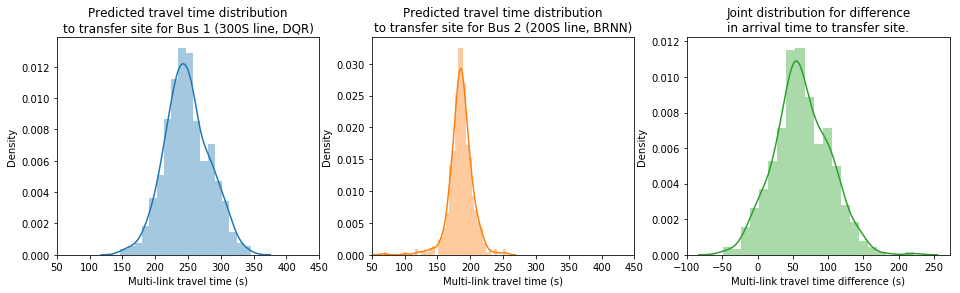

In [167]:
connection_ix = 58
dist_300s = dqr_300s_samples
dist_200s = brnn_200s_samples
fig, ax = plt.subplots(figsize=(16, 4), ncols=3)
sns.distplot(dist_300s[connection_ix], ax=ax[0], color='C0')
ax[0].set_title('Predicted travel time distribution\nto transfer site for Bus 1 (300S line, DQR)')
ax[0].set_xlim(50, 450)
ax[0].set_xlabel('Multi-link travel time (s)')
sns.distplot(dist_200s[connection_ix], ax=ax[1], color='C1')
ax[1].set_title('Predicted travel time distribution\nto transfer site for Bus 2 (200S line, BRNN)')
ax[1].set_xlim(50, 450)
ax[1].set_xlabel('Multi-link travel time (s)')
#sns.distplot(dqr_300s_samples[connection_ix] - brnn_200s_samples[connection_ix] - offset[connection_ix], ax=ax[2], color='C2')
sns.distplot(dist_300s[connection_ix] - dist_200s[connection_ix], ax=ax[2], color='C2')
ax[2].set_title('Joint distribution for difference\nin arrival time to transfer site.')
ax[2].set_xlabel('Multi-link travel time difference (s)')

plt.savefig('dqr-connection-assurance-ex.pdf', bbox_inches='tight')
plt.savefig('dqr-connection-assurance-ex.png', bbox_inches='tight', dpi=300)

In [168]:
connection_data['PredictedArrivalTimeWithHolding_200S'] = connection_data['DepartureTime_300S'] + pd.to_timedelta(connection_data['MultiLinkTravelTime_200S'] + np.quantile(dist_300s - dist_200s, .20, axis=1), unit='s')

In [169]:
connection_data['ConnectionDelayWithHolding_200S'] = (connection_data['ArrivalTime_300S'] - connection_data['PredictedArrivalTimeWithHolding_200S']) / pd.to_timedelta('1s')

In [170]:
#transfer_time = 60 # pd.to_timedelta('1min') / 
#connection_data.loc[lambda x: (connection_data['ConnectionDelayWithHolding_200S'] > -transfer_time) | (transfer_time < connection_data['ConnectionDelayWithHolding_200S']), 'Connection State'] = 'Broken'
#connection_data.loc[lambda x: (connection_data['ConnectionDelayWithHolding_200S'] < -transfer_time) | (transfer_time > connection_data['ConnectionDelayWithHolding_200S']), 'Connection State'] = 'Kept'

In [171]:
connection_data['Connection State'].value_counts()

Broken    249
Kept      190
Name: Connection State, dtype: int64

In [172]:
connection_data.groupby('Connection State')['ConnectionDelayWithHolding_200S'].mean()

Connection State
Broken    44.947998
Kept      14.518868
Name: ConnectionDelayWithHolding_200S, dtype: float64

In [173]:
connection_data['ConnectionDelayWithHolding_200S'].mean()

31.778215557596805

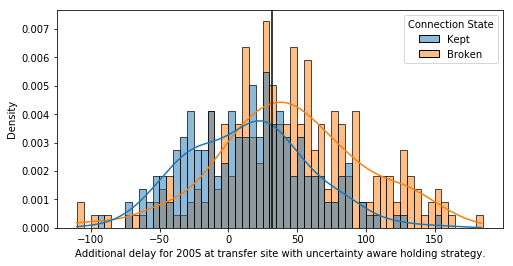

In [174]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=1)
sns.histplot(connection_data, x='ConnectionDelayWithHolding_200S', hue='Connection State', stat='density', kde=True, binwidth=5, color='C0', multiple='layer', shrink=1)
ax.set_xlabel('Additional delay for 200S at transfer site with uncertainty aware holding strategy.')
ax.axvline(connection_data['ConnectionDelayWithHolding_200S'].mean(), color='k')
plt.savefig('additional-delay-200S-with-holding.pdf', bbox_inches='tight')